## Import des données et pré-traitement

In [1]:
import pandas as pd
from src.utility.descriptive_statistics import descriptive_statistics

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-01')]

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
0,1988-01-04,187.50,193.50,198.25,200.00,202.75
1,1988-01-05,187.50,193.25,197.25,198.25,200.75
2,1988-01-06,191.00,195.75,199.75,201.75,204.50
3,1988-01-07,192.75,198.75,202.75,204.50,208.50
4,1988-01-08,192.50,198.00,202.00,203.50,207.25
...,...,...,...,...,...,...
7288,2016-12-23,345.75,352.50,360.00,367.25,376.25
7289,2016-12-27,355.00,361.25,368.50,375.75,384.25
7290,2016-12-28,348.25,354.75,362.00,369.25,378.25
7291,2016-12-29,349.75,355.75,363.00,370.25,379.25


## Statistiques descriptives

In [2]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.0151,0.0001
Median,269.1875,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.9133,0.0172
Skewness,1.53,-1.04
Kurtosis,1.57,19.59
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7312,7311


## Graphiques


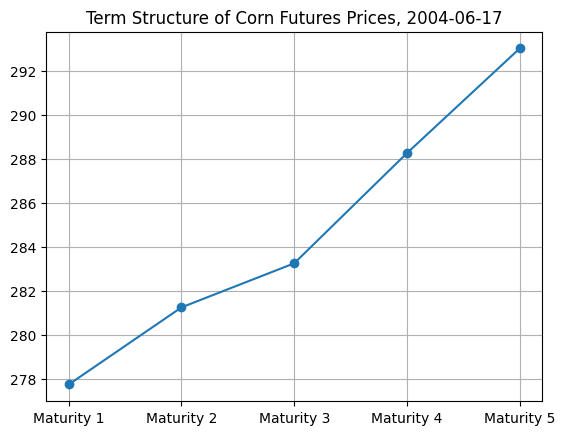

In [3]:
import matplotlib.pyplot as plt
import os 

df.set_index('index', inplace=True)

target_date = '2004-06-17'

prix_17_06_2004 = df.loc[target_date, ['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5']]

plt.plot(['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5'], prix_17_06_2004 , marker='o', linestyle='-')
plt.title(f'Term Structure of Corn Futures Prices, {target_date}')
plt.grid()

output_dir = 'static/graph'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f'term_structure_{target_date}.png')
plt.savefig(output_path)
plt.show()


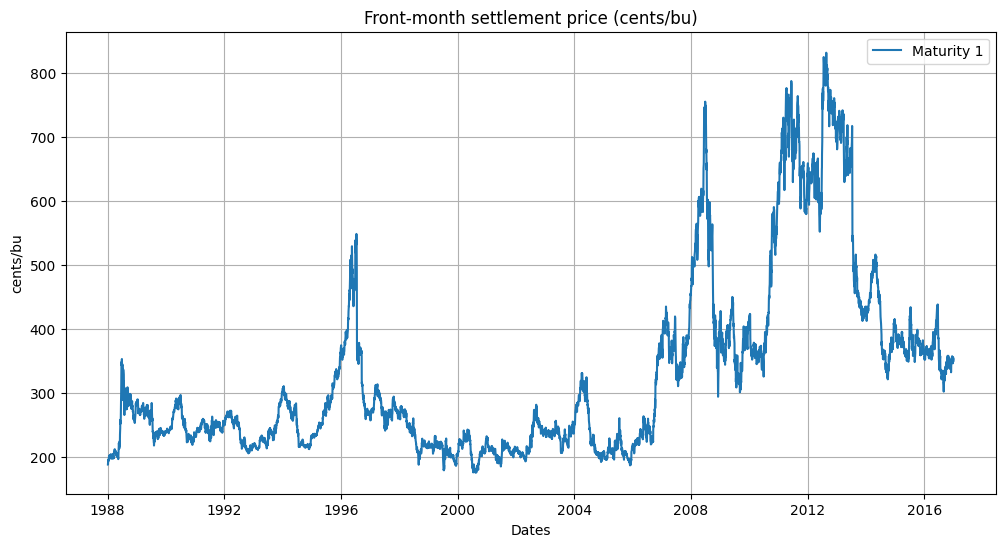

Graph saved to static/graph\price_history.png


In [4]:
from src.graph.graph import plot_and_save_graph

plot_and_save_graph(df, ["Maturity 1"], 
                    "Front-month settlement price (cents/bu)", 
                    "Dates", "cents/bu", 
                    output_filename='price_history.png', 
                    output_dir='static/graph')

# Estimation du modele espace d'etat


## Preparation des données

In [5]:
import pandas as pd
import numpy as np
from src.utility.date import get_T, get_t
df.index = pd.to_datetime(df.index)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = pd.DataFrame(df.index.map(lambda x: pd.Series(get_T(x))).tolist(), index=df.index)
for i in range(1, 6):
    df[f'Maturity {i}'] = np.log(df[f'Maturity {i}'])
df = df[(df.index >= '1988-01-01') & (df.index <= '2016-01-01')]

df['t'] = df.index.to_series().apply(get_t)
df

C:\Users\naiml\AppData\Local\Temp\ipykernel_2084\1251427043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t'] = df.index.to_series().apply(get_t)


,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,T1,T2,T3,T4,T5,t
index,,,,,,,,,,,
1988-01-04,5.233779,5.265278,5.289529,5.298317,5.311974,0.194521,0.361644,0.528767,0.695890,0.947945,0.008219
1988-01-05,5.233779,5.263985,5.284472,5.289529,5.302060,0.191781,0.358904,0.526027,0.693151,0.945205,0.010959
1988-01-06,5.252273,5.276838,5.297067,5.307029,5.320568,0.189041,0.356164,0.523288,0.690411,0.942466,0.013699
1988-01-07,5.261394,5.292048,5.311974,5.320568,5.339939,0.186301,0.353425,0.520548,0.687671,0.939726,0.016438
1988-01-08,5.260096,5.288267,5.308268,5.315666,5.333926,0.183562,0.350685,0.517808,0.684932,0.936986,0.019178
...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,5.898527,5.915528,5.931582,5.943455,5.963579,0.224658,0.391781,0.558904,0.726027,0.978082,0.978082
2015-12-28,5.888878,5.907403,5.923587,5.935555,5.955189,0.213699,0.380822,0.547945,0.715068,0.967123,0.989041
2015-12-29,5.893024,5.910797,5.926926,5.938196,5.957778,0.210959,0.378082,0.545205,0.712329,0.964384,0.991781


In [6]:
# Charger les données de 2017 pour les prévisions out-of-sample
df_oos = pd.read_pickle('src/data/panel_data.pkl')

# Assurez-vous que l'index est correct
if 'index' in df_oos.columns:
    df_oos.set_index('index', inplace=True)
df_oos.index = pd.to_datetime(df_oos.index, errors='coerce')

df_oos = df_oos[~df_oos.index.isin(outlier_dates)]

# Filtrer les données pour l'année 2017
df_oos = df_oos.loc[(df_oos.index > '2016-01-01') & (df_oos.index <= '2017-01-01')]

# Conversion des colonnes en numérique et application de la transformation logarithmique pour 2017
for col in df_oos.columns:
    df_oos[col] = pd.to_numeric(df_oos[col], errors='coerce')

df_oos[['T1', 'T2', 'T3', 'T4', 'T5']] = pd.DataFrame(df_oos.index.map(lambda x: pd.Series(get_T(x))).tolist(), index=df_oos.index)
for i in range(1, 6):
    df_oos[f'Maturity {i}'] = np.log(df_oos[f'Maturity {i}'])
df_oos['t'] = df_oos.index.to_series().apply(get_t)
df_oos

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,T1,T2,T3,T4,T5,t
index,,,,,,,,,,,
2016-01-04,5.862210,5.879135,5.896467,5.910797,5.932245,0.194521,0.361644,0.528767,0.695890,0.947945,0.008219
2016-01-05,5.866468,5.881929,5.899212,5.913503,5.934233,0.191781,0.358904,0.526027,0.693151,0.945205,0.010959
2016-01-06,5.867176,5.881929,5.898527,5.914178,5.935555,0.189041,0.356164,0.523288,0.690411,0.942466,0.013699
2016-01-07,5.866468,5.881929,5.898527,5.914178,5.936876,0.186301,0.353425,0.520548,0.687671,0.939726,0.016438
2016-01-08,5.877736,5.893714,5.910797,5.926259,5.948035,0.183562,0.350685,0.517808,0.684932,0.936986,0.019178
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,5.845716,5.865051,5.886104,5.906043,5.930254,0.224658,0.391781,0.558904,0.726027,0.978082,0.978082
2016-12-27,5.872118,5.889570,5.909441,5.928924,5.951293,0.213699,0.380822,0.547945,0.715068,0.967123,0.989041
2016-12-28,5.852921,5.871413,5.891644,5.911474,5.935555,0.210959,0.378082,0.545205,0.712329,0.964384,0.991781


## Estimation des coefficients de la composante saisonière

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Convertir l'index en datetime
df.index = pd.to_datetime(df.index)

y = df['Maturity 1']

df['Cos1'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df['Sin1'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['Cos2'] = np.cos(4 * np.pi * df.index.dayofyear / 365.25)
df['Sin2'] = np.sin(4 * np.pi * df.index.dayofyear / 365.25)

X = df[['Cos1', 'Sin1', 'Cos2', 'Sin2']]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Extraire les coefficients estimés
coefficients = model.params
seasonal_coeffs = {
    'coeff_Cos1': coefficients[1],
    'coeff_Sin1': coefficients[2],
    'coeff_Cos2': coefficients[3],
    'coeff_Sin2': coefficients[4]
}

## Estimation du modèle espace d'Etat

In [8]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
from src.model.performance import calculate_performance
from src.utility.parameter import calculate_num_parameters
from src.model.optimisation import optimize_model
from src.utility.parameter import initial_guesses

# Paramètres et données d'observation
observations = df.iloc[:, 0:5].values
maturities = df.iloc[:, 5:10].values
times = df['t'].values

# Optimisation et calcul des performances
results = {}
rmse_results = {}
for n_factors in tqdm(range(1, 5)):
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors)
    param_keys = param_keys[:num_params]

    guess = initial_guesses[n_factors]

    if len(guess) != len(param_keys):
        raise ValueError(f"Length of initial_guesses ({len(guess)}) does not match length of param_keys ({len(param_keys)})")

    final_result = optimize_model(observations, times, maturities, n_factors, guess, seasonal_coeffs)
    
    results[n_factors] = final_result
    print(f"Optimized parameters for {n_factors} factors:", final_result.x)

    hessian_inv = final_result.hess_inv
    if isinstance(hessian_inv, np.ndarray):
        covariance_matrix = hessian_inv
    else:
        covariance_matrix = hessian_inv.todense()

    try:
        np.linalg.cholesky(covariance_matrix)
        std_errors = np.sqrt(np.diag(covariance_matrix))
    except np.linalg.LinAlgError:
        std_errors = np.full(covariance_matrix.shape[0], np.inf)

    z_values = final_result.x / std_errors
    p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]

    for i, (param, std_err, p_value) in enumerate(zip(final_result.x, std_errors, p_values)):
        print(f"Parameter {param_keys[i]}: estimate={param}, std_error={std_err}, p_value={p_value}")

    rmse_results[n_factors] = calculate_performance(n_factors, final_result.x, param_keys, observations, times, maturities, seasonal_coeffs, silent=False)

print("RMSE for in-sample data:")
for n_factors, rmses in rmse_results.items():
    print(f"RMSE for {n_factors} factors: {rmses}")

import pickle
with open('src/data/optimization_results.pkl', 'wb') as f:
    pickle.dump(results, f)

  0%|          | 0/4 [00:00<?, ?it/s]

Optimized parameters for 1 factors: [ 0.08379026  0.17616502 -0.01059252]
Parameter mu: estimate=0.08379025963767113, std_error=0.0028076084292445787, p_value=0.0
Parameter sigma1: estimate=0.17616502136433854, std_error=0.002837075318367874, p_value=0.0
Parameter lambda1: estimate=-0.010592518313665334, std_error=0.0021081515666009293, p_value=5.04607641671484e-07
RMSE for 1 factors, Maturity 1: 1.80%
RMSE for 1 factors, Maturity 2: 1.74%
RMSE for 1 factors, Maturity 3: 1.82%
RMSE for 1 factors, Maturity 4: 2.03%


 25%|██▌       | 1/4 [07:01<21:03, 421.27s/it]

RMSE for 1 factors, Maturity 5: 2.35%
Optimized parameters for 2 factors: [ 2.96445917e-02  1.84855507e-01 -1.13328254e-02  8.47621299e-01
  2.61733173e-01  6.43421507e-04 -5.14552997e-01]
Parameter mu: estimate=0.029644591662988776, std_error=0.010704971947440727, p_value=0.005618795209004324
Parameter sigma1: estimate=0.18485550674411227, std_error=0.009823624805007508, p_value=0.0
Parameter lambda1: estimate=-0.011332825366747967, std_error=0.00225334256301566, p_value=4.921715863748233e-07
Parameter kappa2: estimate=0.8476212986304429, std_error=0.11339265466851736, p_value=7.704947790898586e-14
Parameter sigma2: estimate=0.2617331732219317, std_error=0.016248477701566462, p_value=0.0
Parameter lambda2: estimate=0.0006434215071656654, std_error=0.0042086456207537214, p_value=0.8784922027566793
Parameter rho12: estimate=-0.5145529974120485, std_error=0.08048571950844677, p_value=1.6255929935482527e-10
RMSE for 2 factors, Maturity 1: 0.70%
RMSE for 2 factors, Maturity 2: 0.85%
RMSE f

 50%|█████     | 2/4 [15:42<16:00, 480.08s/it]

RMSE for 2 factors, Maturity 5: 1.37%
Optimized parameters for 3 factors: [ 0.01950545  0.15204052 -0.01021301  0.71876112  0.39812294  0.00827591
 -0.52796691  2.29069619  0.22381537  0.00399028  0.04625986 -0.66063103]
Parameter mu: estimate=0.019505453983067206, std_error=0.01619399693343031, p_value=0.22840151822500188
Parameter sigma1: estimate=0.15204051739125368, std_error=0.07619984231179772, p_value=0.046011640403299525
Parameter lambda1: estimate=-0.010213013983766025, std_error=0.002957033217598154, p_value=0.0005527383620842485
Parameter kappa2: estimate=0.7187611215035824, std_error=0.425414983084015, p_value=0.09111352186219435
Parameter sigma2: estimate=0.39812294320124697, std_error=0.291609151673251, p_value=0.17217066444887097
Parameter lambda2: estimate=0.008275907368965092, std_error=0.0044307797634312775, p_value=0.06178690320085334
Parameter rho12: estimate=-0.5279669099801432, std_error=0.651015051054689, p_value=0.4173712249633228
Parameter kappa3: estimate=2.29

 75%|███████▌  | 3/4 [26:34<09:18, 558.57s/it]

RMSE for 3 factors, Maturity 5: 0.95%
Optimized parameters for 4 factors: [ 0.08929588  0.18170342 -0.11051024  1.09816196  0.1640391  -0.09837756
 -0.18502211  0.46479706  0.27864677 -0.09510156 -0.27762447 -0.19013658
  1.35354918  0.28088363 -0.09769732 -0.06049324 -0.35683516 -0.44159681]
Parameter mu: estimate=0.08929587694152083, std_error=0.44795877464511086, p_value=0.841997184728511
Parameter sigma1: estimate=0.18170341991608585, std_error=0.30903592390518747, p_value=0.5565533683788302
Parameter lambda1: estimate=-0.11051024272371565, std_error=0.4475169584451109, p_value=0.8049539587903607
Parameter kappa2: estimate=1.0981619554129782, std_error=2.6240362015534133, p_value=0.6755808051351577
Parameter sigma2: estimate=0.1640391034141177, std_error=0.5781677743018868, p_value=0.7766231869370877
Parameter lambda2: estimate=-0.09837755779040168, std_error=0.44727693082902975, p_value=0.8259118420101177
Parameter rho12: estimate=-0.18502210798558844, std_error=1.5676752081459717

100%|██████████| 4/4 [38:17<00:00, 574.30s/it]

RMSE for 4 factors, Maturity 5: 7.42%
RMSE for in-sample data:
RMSE for 1 factors: [1.800398351467054, 1.737553374143551, 1.8211916011881097, 2.0282616068762844, 2.352871776949373]
RMSE for 2 factors: [0.6961078730214254, 0.8480595217856255, 1.0373805590615455, 1.174096397816573, 1.373708537362523]
RMSE for 3 factors: [0.5994471118942141, 0.6872398353663924, 0.8179667533459392, 0.8644791882716543, 0.9455051323953788]
RMSE for 4 factors: [2.1322649370350706, 3.6512649242374864, 4.9704125913527815, 6.20375012926999, 7.4221155966809045]


## Estimation du modèle débruité


In [9]:
import numpy as np
import scipy.stats as stats
from tqdm import tqdm
from src.model.performance import calculate_performance
from src.utility.parameter import calculate_num_parameters
from src.model.wavelet import denoise_all_signal 
from src.model.optimisation import optimize_model
from src.utility.parameter import initial_guesses

# Denoising the signal
df_denoised = denoise_all_signal(df, wavelet='db1', level=1)

# Preparing the data
observations = df_denoised.iloc[:, 0:5].values
maturities = df_denoised.iloc[:, 5:10].values
times = df_denoised['t'].values

# Optimisation et calcul des performances
results = {}
rmse_results = {}

for n_factors in tqdm(range(1, 5)):
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors)
    param_keys = param_keys[:num_params]

    guess = initial_guesses[n_factors]

    if len(guess) != len(param_keys):
        raise ValueError(f"Length of initial_guesses ({len(guess)}) does not match length of param_keys ({len(param_keys)})")

    final_result = optimize_model(observations, times, maturities, n_factors, guess, seasonal_coeffs)
    
    results[n_factors] = final_result
    print(f"Optimized parameters for {n_factors} factors:", final_result.x)

    hessian_inv = final_result.hess_inv
    if isinstance(hessian_inv, np.ndarray):
        covariance_matrix = hessian_inv
    else:
        covariance_matrix = hessian_inv.todense()

    try:
        np.linalg.cholesky(covariance_matrix)
        std_errors = np.sqrt(np.diag(covariance_matrix))
    except np.linalg.LinAlgError:
        std_errors = np.full(covariance_matrix.shape[0], np.inf)

    z_values = final_result.x / std_errors
    p_values = [2 * (1 - stats.norm.cdf(np.abs(z))) for z in z_values]

    for i, (param, std_err, p_value) in enumerate(zip(final_result.x, std_errors, p_values)):
        print(f"Parameter {param_keys[i]}: estimate={param}, std_error={std_err}, p_value={p_value}")

    rmse_results[n_factors] = calculate_performance(n_factors, final_result.x, param_keys, observations, times, maturities, seasonal_coeffs, silent=False)

# Affichage des résultats RMSE
print("RMSE for in-sample data:")
for n_factors, rmses in rmse_results.items():
    print(f"RMSE for {n_factors} factors: {rmses}")
    
# Sauvegarde des résultats pour réutilisation
import pickle
with open('src/data/optimization_results_denoised.pkl', 'wb') as f:
    pickle.dump(results, f)


  0%|          | 0/4 [00:00<?, ?it/s]

Optimized parameters for 1 factors: [ 0.07923984  0.14295091 -0.01093118]
Parameter mu: estimate=0.07923983617412522, std_error=0.0010106657458609537, p_value=0.0
Parameter sigma1: estimate=0.1429509107968542, std_error=0.0028441906241179313, p_value=0.0
Parameter lambda1: estimate=-0.01093118463923172, std_error=0.0010276350172255912, p_value=0.0
RMSE for 1 factors, Maturity 1: 1.72%
RMSE for 1 factors, Maturity 2: 1.63%
RMSE for 1 factors, Maturity 3: 1.68%
RMSE for 1 factors, Maturity 4: 1.87%


 25%|██▌       | 1/4 [10:25<31:17, 625.69s/it]

RMSE for 1 factors, Maturity 5: 2.16%
Optimized parameters for 2 factors: [ 0.02755336  0.1711981  -0.01133282  0.81418028  0.2382016   0.00173065
 -0.6316657 ]
Parameter mu: estimate=0.027553356880452528, std_error=0.01063661389374072, p_value=0.009585734076159147
Parameter sigma1: estimate=0.17119810250994133, std_error=0.027112720903191136, p_value=2.713709257307073e-10
Parameter lambda1: estimate=-0.011332820876546749, std_error=0.0026100254850788284, p_value=1.4116931561503065e-05
Parameter kappa2: estimate=0.814180276539665, std_error=0.22294714345429953, p_value=0.00026030905748686273
Parameter sigma2: estimate=0.23820160318400868, std_error=0.03418058275553836, p_value=3.1938895972416503e-12
Parameter lambda2: estimate=0.0017306498105078968, std_error=0.004162000285890495, p_value=0.6775405180331209
Parameter rho12: estimate=-0.6316656995305602, std_error=0.14485793629917074, p_value=1.2971372542969206e-05
RMSE for 2 factors, Maturity 1: 0.65%
RMSE for 2 factors, Maturity 2: 0.

 50%|█████     | 2/4 [19:36<19:22, 581.43s/it]

RMSE for 2 factors, Maturity 5: 1.27%
Optimized parameters for 3 factors: [ 0.00926216  0.13712701 -0.00841597  0.88719765  0.34754397  0.00304134
 -0.31661956  1.74160363  0.19200091  0.00455014 -0.25974932 -0.74864462]
Parameter mu: estimate=0.009262162649444343, std_error=0.013879593210622772, p_value=0.5045662582137245
Parameter sigma1: estimate=0.1371270072295421, std_error=0.060493008450958445, p_value=0.02340097551399478
Parameter lambda1: estimate=-0.008415965104077685, std_error=0.002643788917777936, p_value=0.0014560821752636066
Parameter kappa2: estimate=0.8871976528565075, std_error=0.31526981916827, p_value=0.004891552775482477
Parameter sigma2: estimate=0.34754397438757445, std_error=0.1887121497494524, p_value=0.06552462198688991
Parameter lambda2: estimate=0.003041342536840136, std_error=0.00461735864750078, p_value=0.5101039573486976
Parameter rho12: estimate=-0.31661955865139757, std_error=0.7906765397619684, p_value=0.6888314942401474
Parameter kappa3: estimate=1.741

 75%|███████▌  | 3/4 [30:35<10:16, 616.87s/it]

RMSE for 3 factors, Maturity 5: 0.74%
Optimized parameters for 4 factors: [ 0.09604281  0.13148833 -0.08608617  0.54694991  0.23030444 -0.07804075
 -0.17402827  1.4468822   0.22403498 -0.07555345 -0.15129948 -0.55662483
  0.65746273  0.24827187 -0.07998358 -0.16825505 -0.23494687 -0.30756487]
Parameter mu: estimate=0.09604281388291189, std_error=0.4643217449014492, p_value=0.8361306040488474
Parameter sigma1: estimate=0.13148833235212024, std_error=0.7859884664011838, p_value=0.8671415499686865
Parameter lambda1: estimate=-0.08608617476136211, std_error=0.44745827035706626, p_value=0.8474372883552246
Parameter kappa2: estimate=0.5469499132601523, std_error=0.5880222981258513, p_value=0.35229256942569087
Parameter sigma2: estimate=0.23030443792851593, std_error=0.9818375767864159, p_value=0.8145466094745233
Parameter lambda2: estimate=-0.07804074655939, std_error=0.45106260347594973, p_value=0.8626393753603405
Parameter rho12: estimate=-0.17402826548912345, std_error=1.4140722050109091,

100%|██████████| 4/4 [42:52<00:00, 643.13s/it]

RMSE for 4 factors, Maturity 5: 6.52%
RMSE for in-sample data:
RMSE for 1 factors: [1.7165585726620844, 1.6274886867622869, 1.6830783751053624, 1.8655678416757793, 2.160114140068031]
RMSE for 2 factors: [0.6489642814924791, 0.8061853113988519, 0.974025790865234, 1.091638402706154, 1.2661825553760884]
RMSE for 3 factors: [0.5322042584905435, 0.6046572244474158, 0.7109265360787694, 0.7185612633513841, 0.7388081657494568]
RMSE for 4 factors: [2.0069968911499947, 3.2621304661677244, 4.370446903052996, 5.437052195485482, 6.519428784510839]


## Out of sample tracking result

In [10]:
import numpy as np
from tqdm import tqdm
from src.model.performance import calculate_performance
from src.utility.parameter import calculate_num_parameters

# Chargement des résultats de l'optimisation
import pickle
with open('src/data/optimization_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Paramètres et données d'observation pour les prévisions out-of-sample
observations = df_oos.iloc[:, 0:5].values
maturities = df_oos.iloc[:, 5:10].values
times = df_oos['t'].values

# Optimisation et calcul des performances out-of-sample
oos_results = {}

for n_factors in tqdm(range(1, 5)):
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors)
    param_keys = param_keys[:num_params]

    # Récupération des paramètres optimisés
    final_result = results[n_factors]
    optimized_params = final_result.x

    # Prévisions à 5 jours à l'avance
    forecast_horizon = 5
    rmse_forecast = [[] for _ in range(observations.shape[1])]  # Initialiser une liste pour chaque maturité

    for t in range(len(times) - forecast_horizon):
        current_observations = observations[:t + forecast_horizon]
        current_times = times[:t + forecast_horizon]
        current_maturities = maturities[:t + forecast_horizon]

        future_observations = observations[t + forecast_horizon]

        # Prévisions pour la date t+5
        predicted_prices = calculate_performance(n_factors, optimized_params, param_keys, current_observations, current_times, current_maturities, seasonal_coeffs, silent=True)
        actual_prices = future_observations

        # Assurez-vous que predicted_prices et actual_prices sont des tableaux NumPy 2D
        predicted_prices = np.array(predicted_prices)
        actual_prices = np.array(actual_prices)

        # Reshape les tableaux si nécessaire
        if predicted_prices.ndim == 1:
            predicted_prices = predicted_prices.reshape(1, -1)
        if actual_prices.ndim == 1:
            actual_prices = actual_prices.reshape(1, -1)

        # Calcul de la RMSE pour chaque maturité
        for maturity_index in range(observations.shape[1]):
            rmse = np.sqrt(np.mean((predicted_prices[0, maturity_index] - actual_prices[0, maturity_index]) ** 2))
            rmse_forecast[maturity_index].append(rmse)

    # Moyenne des RMSE sur les prévisions à 5 jours pour chaque maturité
    mean_rmse_forecast = [np.mean(rmse_list) for rmse_list in rmse_forecast]
    rmse_results[n_factors] = mean_rmse_forecast

# Affichage des résultats RMSE pour les données out-of-sample
print("RMSE for out-of-sample data (5-day ahead forecasts):")
for n_factors, mean_rmse_list in rmse_results.items():
    print(f"Out-of-sample RMSE for {n_factors} factors:")
    for maturity_index, mean_rmse in enumerate(mean_rmse_list):
        print(f"  Maturity {maturity_index + 1}: {mean_rmse:.2f}%")



100%|██████████| 4/4 [00:55<00:00, 13.95s/it]

RMSE for out-of-sample data (5-day ahead forecasts):
Out-of-sample RMSE for 1 factors:
  Maturity 1: 4.58%
  Maturity 2: 4.47%
  Maturity 3: 4.37%
  Maturity 4: 4.28%
  Maturity 5: 4.22%
Out-of-sample RMSE for 2 factors:
  Maturity 1: 5.41%
  Maturity 2: 5.20%
  Maturity 3: 5.01%
  Maturity 4: 4.86%
  Maturity 5: 4.77%
Out-of-sample RMSE for 3 factors:
  Maturity 1: 5.45%
  Maturity 2: 5.37%
  Maturity 3: 5.26%
  Maturity 4: 5.17%
  Maturity 5: 5.12%
Out-of-sample RMSE for 4 factors:
  Maturity 1: 4.28%
  Maturity 2: 2.87%
  Maturity 3: 1.56%
  Maturity 4: 0.44%
  Maturity 5: 0.92%


## Wavelet Out of sample tracking result

In [11]:
import numpy as np
from tqdm import tqdm
from src.model.performance import calculate_performance
from src.utility.parameter import calculate_num_parameters
from src.model.wavelet import denoise_all_signal

# Chargement des résultats de l'optimisation
import pickle
with open('src/data/optimization_results_denoised.pkl', 'rb') as f:
    results = pickle.load(f)

# Denoising the out-of-sample signal
df_oos_denoised = denoise_all_signal(df_oos, wavelet='db1', level=1)

# Paramètres et données d'observation pour les prévisions out-of-sample
observations_oos = df_oos_denoised.iloc[:, 0:5].values
maturities_oos = df_oos_denoised.iloc[:, 5:10].values
times_oos = df_oos_denoised['t'].values

# Optimisation et calcul des performances out-of-sample
rmse_oos_results = {}

for n_factors in tqdm(range(1, 5)):
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    num_params = calculate_num_parameters(n_factors)
    param_keys = param_keys[:num_params]

    # Récupération des paramètres optimisés
    final_result = results[n_factors]
    optimized_params = final_result.x

    # Prévisions à 5 jours à l'avance
    forecast_horizon = 5
    rmse_forecast = [[] for _ in range(observations_oos.shape[1])]  # Initialiser une liste pour chaque maturité

    for t in range(len(times_oos) - forecast_horizon):
        current_observations = observations_oos[:t + forecast_horizon]
        current_times = times_oos[:t + forecast_horizon]
        current_maturities = maturities_oos[:t + forecast_horizon]

        future_observations = observations_oos[t + forecast_horizon]

        # Prévisions pour la date t+5
        predicted_prices = calculate_performance(n_factors, optimized_params, param_keys, current_observations, current_times, current_maturities, seasonal_coeffs, silent=True)
        actual_prices = future_observations

        # Assurez-vous que predicted_prices et actual_prices sont des tableaux NumPy 2D
        predicted_prices = np.array(predicted_prices)
        actual_prices = np.array(actual_prices)

        # Reshape les tableaux si nécessaire
        if predicted_prices.ndim == 1:
            predicted_prices = predicted_prices.reshape(1, -1)
        if actual_prices.ndim == 1:
            actual_prices = actual_prices.reshape(1, -1)

        # Calcul de la RMSE pour chaque maturité
        for maturity_index in range(observations_oos.shape[1]):
            rmse = np.sqrt(np.mean((predicted_prices[0, maturity_index] - actual_prices[0, maturity_index]) ** 2))
            rmse_forecast[maturity_index].append(rmse)

    # Moyenne des RMSE sur les prévisions à 5 jours pour chaque maturité
    mean_rmse_forecast = [np.mean(rmse_list) for rmse_list in rmse_forecast]
    rmse_oos_results[n_factors] = mean_rmse_forecast

# Affichage des résultats RMSE pour les données out-of-sample
print("RMSE for out-of-sample data (5-day ahead forecasts):")
for n_factors, mean_rmse_list in rmse_oos_results.items():
    print(f"Out-of-sample RMSE for {n_factors} factors:")
    for maturity_index, mean_rmse in enumerate(mean_rmse_list):
        print(f"  Maturity {maturity_index + 1}: {mean_rmse:.2f}%")


100%|██████████| 4/4 [00:55<00:00, 13.97s/it]

RMSE for out-of-sample data (5-day ahead forecasts):
Out-of-sample RMSE for 1 factors:
  Maturity 1: 4.62%
  Maturity 2: 4.54%
  Maturity 3: 4.47%
  Maturity 4: 4.41%
  Maturity 5: 4.39%
Out-of-sample RMSE for 2 factors:
  Maturity 1: 5.44%
  Maturity 2: 5.25%
  Maturity 3: 5.06%
  Maturity 4: 4.93%
  Maturity 5: 4.87%
Out-of-sample RMSE for 3 factors:
  Maturity 1: 5.51%
  Maturity 2: 5.46%
  Maturity 3: 5.38%
  Maturity 4: 5.33%
  Maturity 5: 5.34%
Out-of-sample RMSE for 4 factors:
  Maturity 1: 4.41%
  Maturity 2: 3.25%
  Maturity 3: 2.13%
  Maturity 4: 1.04%
  Maturity 5: 0.33%
